<a href="https://colab.research.google.com/github/zile56/ElevvoPathways/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor


In [1]:
from google.colab import files
import pandas as pd

# upload train.csv
uploaded = files.upload()
train = pd.read_csv("train.csv")

# upload features.csv
uploaded = files.upload()
features = pd.read_csv("features.csv")

# upload stores.csv
uploaded = files.upload()
stores = pd.read_csv("stores.csv")


Saving train.csv to train.csv


Saving features.csv to features.csv


Saving stores.csv to stores.csv


In [2]:
import pandas as pd

train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

print("Train shape:", train.shape)
print("Features shape:", features.shape)
print("Stores shape:", stores.shape)

train.head()


Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
# Merge train with stores
data = train.merge(stores, on="Store", how="left")

# Merge with features (on Store and Date)
data = data.merge(features, on=["Store", "Date"], how="left")

print("Final dataset shape:", data.shape)
data.head()


Final dataset shape: (421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
#converting date column to datetime
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(["Store", "Dept", "Date"])


In [9]:
# creating time based features

data["Year"]=data["Date"].dt.year
data["Month"]=data["Date"].dt.month
data["Week"]=data["Date"].dt.isocalendar().week
data["Day"]=data["Date"].dt.day

In [11]:
print(data.columns.tolist())


['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Year', 'Month', 'Week', 'Day']


In [13]:
if "IsHoliday_x" in data.columns:
    data["IsHoliday"] = data["IsHoliday_x"]   # keep one
    data = data.drop(columns=["IsHoliday_x", "IsHoliday_y"], errors="ignore")


In [14]:
# defining target and features
features_cols = ["Store", "Dept", "IsHoliday", "Year", "Month", "Week", "Day",
                 "Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"]

X = data[features_cols]
y = data[target]

In [16]:
# train and test splits
split_date = "2012-06-01"  # keep last months for testing

train_data = data[data["Date"] < split_date]
test_data  = data[data["Date"] >= split_date]

X_train = train_data[features_cols]
y_train = train_data[target]

X_test = test_data[features_cols]
y_test = test_data[target]


In [17]:
# now training the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 21041.541798055554
R²: 0.08744687688491548


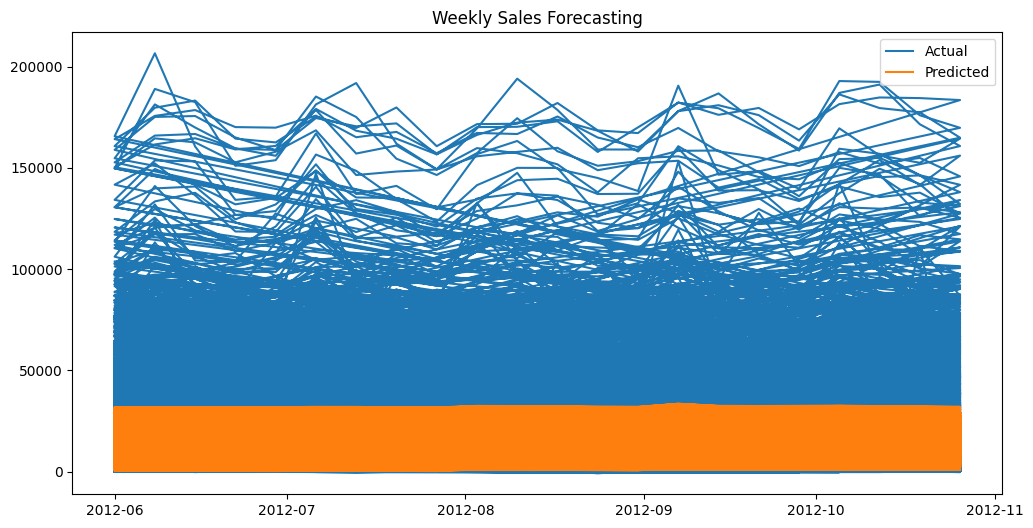

In [18]:
# plotting actual vs predicted sales
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_data["Date"], y_test.values, label="Actual")
plt.plot(test_data["Date"], y_pred, label="Predicted")
plt.legend()
plt.title("Weekly Sales Forecasting")
plt.show()


In [25]:
# trying a demo prediction where we will input any store,dept,date and other conds and model will predict the weekly sales
# User inputs
store = int(input("Enter Store number (e.g. 1): "))
dept = int(input("Enter Department number (e.g. 1): "))
date = input("Enter Date (YYYY-MM-DD, e.g. 2012-12-25): ")
is_holiday = input("Is it a holiday week? (yes/no): ").strip().lower() == "yes"

# Build demo row (with some average values for missing features)
demo = pd.DataFrame([{
    "Store": store,
    "Dept": dept,
    "IsHoliday": is_holiday,
    "Date": date,
    "Temperature": data["Temperature"].mean(),
    "Fuel_Price": data["Fuel_Price"].mean(),
    "CPI": data["CPI"].mean(),
    "Unemployment": data["Unemployment"].mean(),
    "Size": data["Size"].mean()
}])

# Feature engineering (same as training)
demo["Date"] = pd.to_datetime(demo["Date"])
demo["Year"] = demo["Date"].dt.year
demo["Month"] = demo["Date"].dt.month
demo["Week"] = demo["Date"].dt.isocalendar().week.astype(int)
demo["Day"] = demo["Date"].dt.day

demo_features = demo[features_cols]

# Predict
predicted_sales = model.predict(demo_features)[0]
print(f"\n✅ Predicted Weekly Sales for Store {store}, Dept {dept} on {date}: {predicted_sales:.2f}")


Enter Store number (e.g. 1): 3
Enter Department number (e.g. 1): 4
Enter Date (YYYY-MM-DD, e.g. 2012-12-25): 2019-11-10
Is it a holiday week? (yes/no): yes

✅ Predicted Weekly Sales for Store 3, Dept 4 on 2019-11-10: 12390.72
